In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Basic Classification: Classify Images of Clothing

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

In [2]:
# PyTorch library import
import torch
from torch import nn

print(torch.__version__)

1.7.1


## Import the Fashion MNIST dataset

This guide uses the Fashion MNIST dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here. We will use the [`torchvision`](https://pytorch.org/docs/stable/torchvision/datasets.html), which is a library that deals with the vision related things used in PyTorch.

![](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

In [3]:
# Location to store the dataset
import os
data_path = os.path.expanduser('~/data')

from torchvision.datasets import FashionMNIST

train_set = FashionMNIST(data_path, train=True, download=True)
test_set = FashionMNIST(data_path, train=False, download=True)

Loading the dataset returns an array of tuples.
Every tuple has a 28x28 PIL image and class number that ranges from 0 to 9.
The class can be converted to the label by checking on its appropriate entry in the `train_set.classes` array.
To convert from the label back to the class, you can use `train_class.class_to_idx`.

| Label | Class       |
|:-----:|:------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

In [4]:
# All labels sorted by the class number
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# All labels mapping to the class numbers
train_set.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

(-0.5, 27.5, 27.5, -0.5)

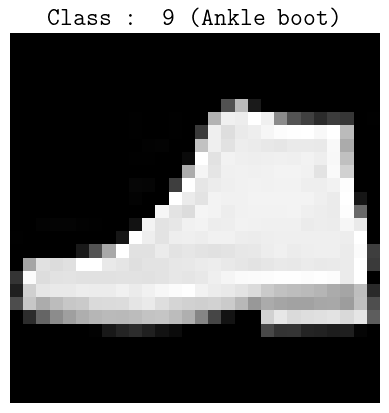

In [6]:
# Show one of the images
index = 42

img = train_set[index][0]
cls = train_set[index][1]
label = train_set.classes[cls]

plt.imshow(img, cmap='gray')
plt.title(f'Class : {cls} ({label})')
plt.axis('off')

## Preprocess the data

Before you can train the image, you should preprocess the data.
To do that you must attach a transform object while loading the training set.
`torchvision` library provides most common transformations you might require.
One of the transforms you will use very often is the `torchvision.transforms.ToTensor`, which converts an image to the PyTorch tensor while also normalizing the values to be in range 0.0 to 1.0.
The images are also converted from the `HxWxC` format into `CxHxW`, which is the default for most PyTorch applications.

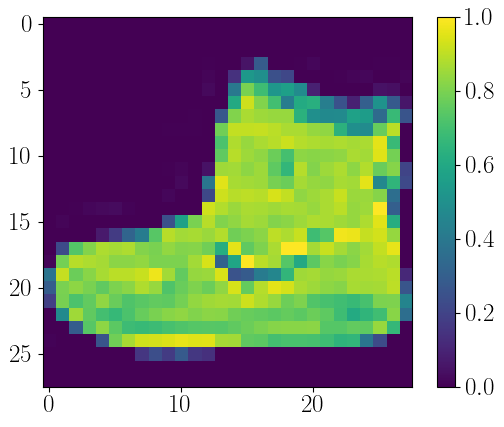

In [7]:
from torchvision import transforms
transform = transforms.ToTensor()
train_set = FashionMNIST(data_path, train=True, download=True, transform=transform)
test_set = FashionMNIST(data_path, train=False, download=True, transform=transform)

image = train_set[0][0].reshape(28, 28, 1)

plt.imshow(image)
plt.colorbar()

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

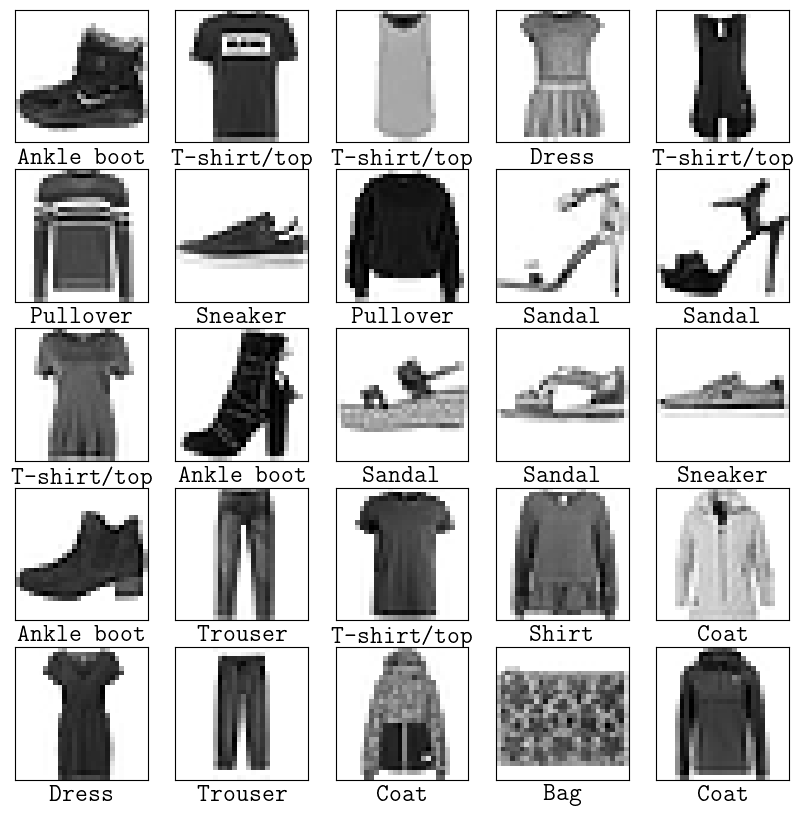

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    img = train_set[i][0].reshape(28, 28, 1)
    cls = train_set[i][1]
    lbl = train_set.classes[cls]
    
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(lbl)
plt.show()

## Setup a Data Loader

PyTorch provides another convenient utility for manipulating the data. [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is a class that allows iterating over the dataset.

In [9]:
from torch.utils.data import DataLoader

batch_size = 2048

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

The DataLoader can take many parameters, but the most commonly used one is the `batch_size`, which controls the size of a minibatch at every iteration.
Note that if you call `len` on the DataLoader, it will return the number of batches (NOT the number of samples).

In [10]:
train_sample_num = len(train_set)
train_batch_num = len(train_loader)
print(f'Number of samples in the training set: {train_sample_num}')
print(f'Number of training batches: {train_batch_num}')

Number of samples in the training set: 60000
Number of training batches: 30


While iterating over the `DataLoader`, you get the sub-sampled data of maximum size `batch_size`.

In [11]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([2048, 1, 28, 28]) torch.Size([2048])


## Building the model

Building the model requires configuring the neural layers.

### Set up the layers

All the basic building blocks in PyTorch are located in the `torch.nn` library.
The neural networks are composed of the "layers", and the simplext layer is `torch.nn.Linear`.
The `Linear` layer multiplies every element in the input by some weight, which means that the input must be "flattened" -- converted into a one-dimensional array. 

$$
y = \sum_i x_i w_i + b
$$

Most of deep learning consists of chaining together simple layers. Most layers, have the learnable parameters (such as the $w_i$ in the example above).

In [12]:
from torch import nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)


The first layer in this network, `nn.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `nn.Linear` layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

Notice that the first `Linear` layer is followed by the `nnReLU`, which is called an activation function.
This function is needed to preserve the non-linear relationship inbetween the layers.

### Setup the training-time objects

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- Loss function — Also known as "criterion" — this measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction. Most loss functions are located in the `torch.nn` library.
- Optimizer — This is how the model is updated based on the data it sees and its loss function. The optimizers are used in the `torch.optim` library.

In [13]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()

The optimizer is instantiated by taking the model parameters (`model.parameters()`).

### Train the model

To train a model in PyTorch without additional libraries (such as [Tez](https://pypi.org/project/tez/) or [Lightning](https://www.pytorchlightning.ai/)), you need to go through a specific set of steps at every training iteration:

1. Reset the optimizer using `optimizer.zero_grad()`. This step is needed either in beginning or in the end of the loop. It resets the optimizer and prepares it for the new computation.
2. Get the prediction of the model you are training using `prediction = model(input)`. This step makes the prediction.
3. Compute the loss between the prediction and the true label using `loss = criterion(prediction, true_class)`.  At this point we are finding the difference between the prediction and the target class.
4. Compute the gradients by calling the backwards on the loss using `loss.backward()`. The `backward()` method computes the gradients.
5. Update the weights using the `optimizer.step()`. This is the last step and it changes the model.

This is the pseudocode that you would need to implement in Python:

```python
# This loop describes a single training loop
for image, true_class in training_data:
    optimier.zero_grad()  # Step 1: Reset the optimizer
    predicted_class = model(image)  # Step 2: Run the prediction
    loss = criterion(predicted_class, true_class)  # Step 3: Compute the loss
    loss.backward()  # Compute the derivatives
    optimizer.step()  # Update the weights using the computed derivatives
```

The above loop has to be repeated many times called "epochs":

```python
for epoch in range(epochs):
    # Repeat the loop described above
```

#### Metrics

The classification model that we have predicts the class of an image.
The prediction is shown as 10 numbers with the largest one being the position of the most likely prediction.
For example, if the prediction is `[1.0, 1.2, 1.5, 1.3, 0.9]`, the class is `2` because the element at this index (`1.5`) is the largest in this row of numbers (remember, the counting is 0-based).
The index of the maximum element can be found using the `.argmax()` method.

Often times when running the predictions, you don't run it on a single image, but a stack of images (aka minibatch).
Once you find the location of the maximum element for every image in the minibatch (which are the predictions), you can find the accuracy by dividing the number of correct predctions by the total number of images in the minibatch.

```python
predicted_classes = model(image)
predictions = predicted_classes.argmax(axis=1)
accuracy = (predictions == true_classes).float().mean()
```

In [14]:
model.train()  # This makes sure the model is set to training mode

epochs = 30

for epoch in range(epochs):
    print(f'{epoch+1:0>2} / {epochs}', end=' ')
    running_loss = 0.0
    running_accuracy = 0.0
    for imgs, tgts in train_loader:       
        optimizer.zero_grad()
        tgts_logits = model(imgs)
        loss = criterion(tgts_logits, tgts)
        loss.backward()
        optimizer.step()
        
        # Compute the metrics (s.a. epoch accuracy and loss)
        predictions = tgts_logits.argmax(axis=1)
        accuracy = (predictions == tgts).float().mean()
        
        # Sum up the metrics to later normalize them by the total number of images
        running_loss += loss.item() * len(imgs)
        running_accuracy += accuracy.item() * len(imgs)
        
        print('.', end='')

    running_loss /= len(train_set)
    running_accuracy /= len(train_set)
    print(f' - loss: {running_loss:.4f} - accuracy: {running_accuracy:.4%}')
        
        

01 / 30 .............................. - loss: 0.8605 - accuracy: 69.9117%
02 / 30 .............................. - loss: 0.5018 - accuracy: 82.5300%
03 / 30 .............................. - loss: 0.4420 - accuracy: 84.5783%
04 / 30 .............................. - loss: 0.4086 - accuracy: 85.8000%
05 / 30 .............................. - loss: 0.3863 - accuracy: 86.4833%
06 / 30 .............................. - loss: 0.3741 - accuracy: 86.9167%
07 / 30 .............................. - loss: 0.3560 - accuracy: 87.4417%
08 / 30 .............................. - loss: 0.3425 - accuracy: 87.8833%
09 / 30 .............................. - loss: 0.3322 - accuracy: 88.2217%
10 / 30 .............................. - loss: 0.3192 - accuracy: 88.6350%
11 / 30 .............................. - loss: 0.3145 - accuracy: 88.6783%
12 / 30 .............................. - loss: 0.3029 - accuracy: 89.0367%
13 / 30 .............................. - loss: 0.2990 - accuracy: 89.0517%
14 / 30 .................

The model reaches the accuracy of almost 92%

### Evaluate accuracy
Next, compare how the model performs on the test dataset.

To evaluate the model we run a very similar loop as we did in the training section.
One difference is that the is no need to compute the gradients any more.
That means you don't need to call the optimizer and no need to compute the gradients using the `backward()` method.

In [15]:
model.eval()

running_loss = 0.0
running_accuracy = 0.0
for imgs, tgts in test_loader:
    tgts_logits = model(imgs)
    loss = criterion(tgts_logits, tgts)

    predictions = tgts_logits.argmax(axis=1)
    accuracy = (predictions == tgts).float().mean()

    running_loss += loss.item() * len(imgs)
    running_accuracy += accuracy.item() * len(imgs)

    print('.', end='')

running_loss /= len(test_set)
running_accuracy /= len(test_set)
print(f' - loss: {running_loss:.4f} - accuracy: {running_accuracy:.4%}')

..... - loss: 0.3346 - accuracy: 87.9800%


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents overfitting. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:

- [Demonstrate overfitting](#TODO)
- [Strategies to prevent overfitting](#TODO)

### Make predictions

With the model trained, you can use it to make predictions about some images. The model's linear outputs, logits. Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

In [16]:
probability_model = nn.Sequential(
    model,
    nn.Softmax(dim=1)
)

probability_model.eval()

img, lbl = test_set[0]
prediction = probability_model(img)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [17]:
prediction

tensor([[5.0439e-08, 1.0730e-11, 5.3220e-09, 1.9435e-10, 1.7419e-09, 1.1201e-03,
         1.7632e-07, 1.4850e-02, 8.2943e-06, 9.8402e-01]],
       grad_fn=<SoftmaxBackward>)

In [18]:
print(f'Model believes the class is {prediction.argmax()}')

Model believes the class is 9


So, the model is most confident that this image is an ankle boot, or `train_set.classes[9]`. Examining the test label shows that this classification is correct:

In [19]:
print(f'The real class is {lbl} -- {train_set.classes[lbl]}')

The real class is 9 -- Ankle boot


*The functions below are for visualizing the results*

In [20]:
def plot_image(img, true_class, predictions_array, class_names):
    predictions_array = predictions_array.detach().flatten()
    predicted_class = predictions_array.argmax()
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    if isinstance(img, torch.Tensor) and img.ndim == 3:
        img = img.permute(1, 2, 0)
        img = img.detach()
        img = img.numpy()

    plt.imshow(img, cmap=plt.cm.binary)
    
    if true_class < 0:
        color = "#777777"
    else:
        if predicted_class == true_class:
            color = 'blue'
        else:
            color = 'red'
    
    class_name = class_names[predicted_class]
    confidence = predictions_array.max()
    
    label = f"{class_name} {confidence:2.0%}"
    if true_class >= 0:
        true_class_name = class_names[true_class]
        label += f'\n({true_class_name})'
    plt.xlabel(label, color=color)

def plot_value_array(img, true_class, predictions_array):
    predictions_array = predictions_array.detach().flatten()
    predicted_class = predictions_array.argmax()
    
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    
    thisplot[predicted_class].set_color('red')
    if true_class >= 0:
        thisplot[true_class].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

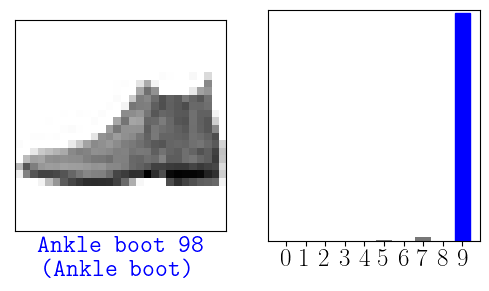

In [21]:
i = 0

img, true_class = test_set[i]
predictions_array = probability_model(img)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(img, true_class, predictions_array, test_set.classes)
plt.subplot(1,2,2)
plot_value_array(img, true_class, predictions_array)
plt.show()

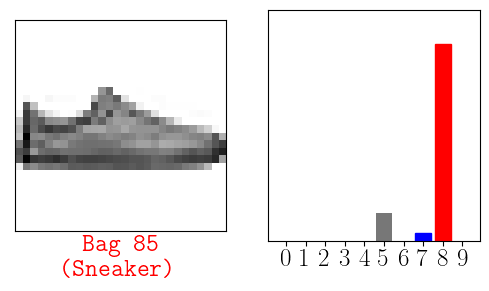

In [22]:
i = 12

img, true_class = test_set[i]
predictions_array = probability_model(img)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(img, true_class, predictions_array, test_set.classes)
plt.subplot(1,2,2)
plot_value_array(img, true_class, predictions_array)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

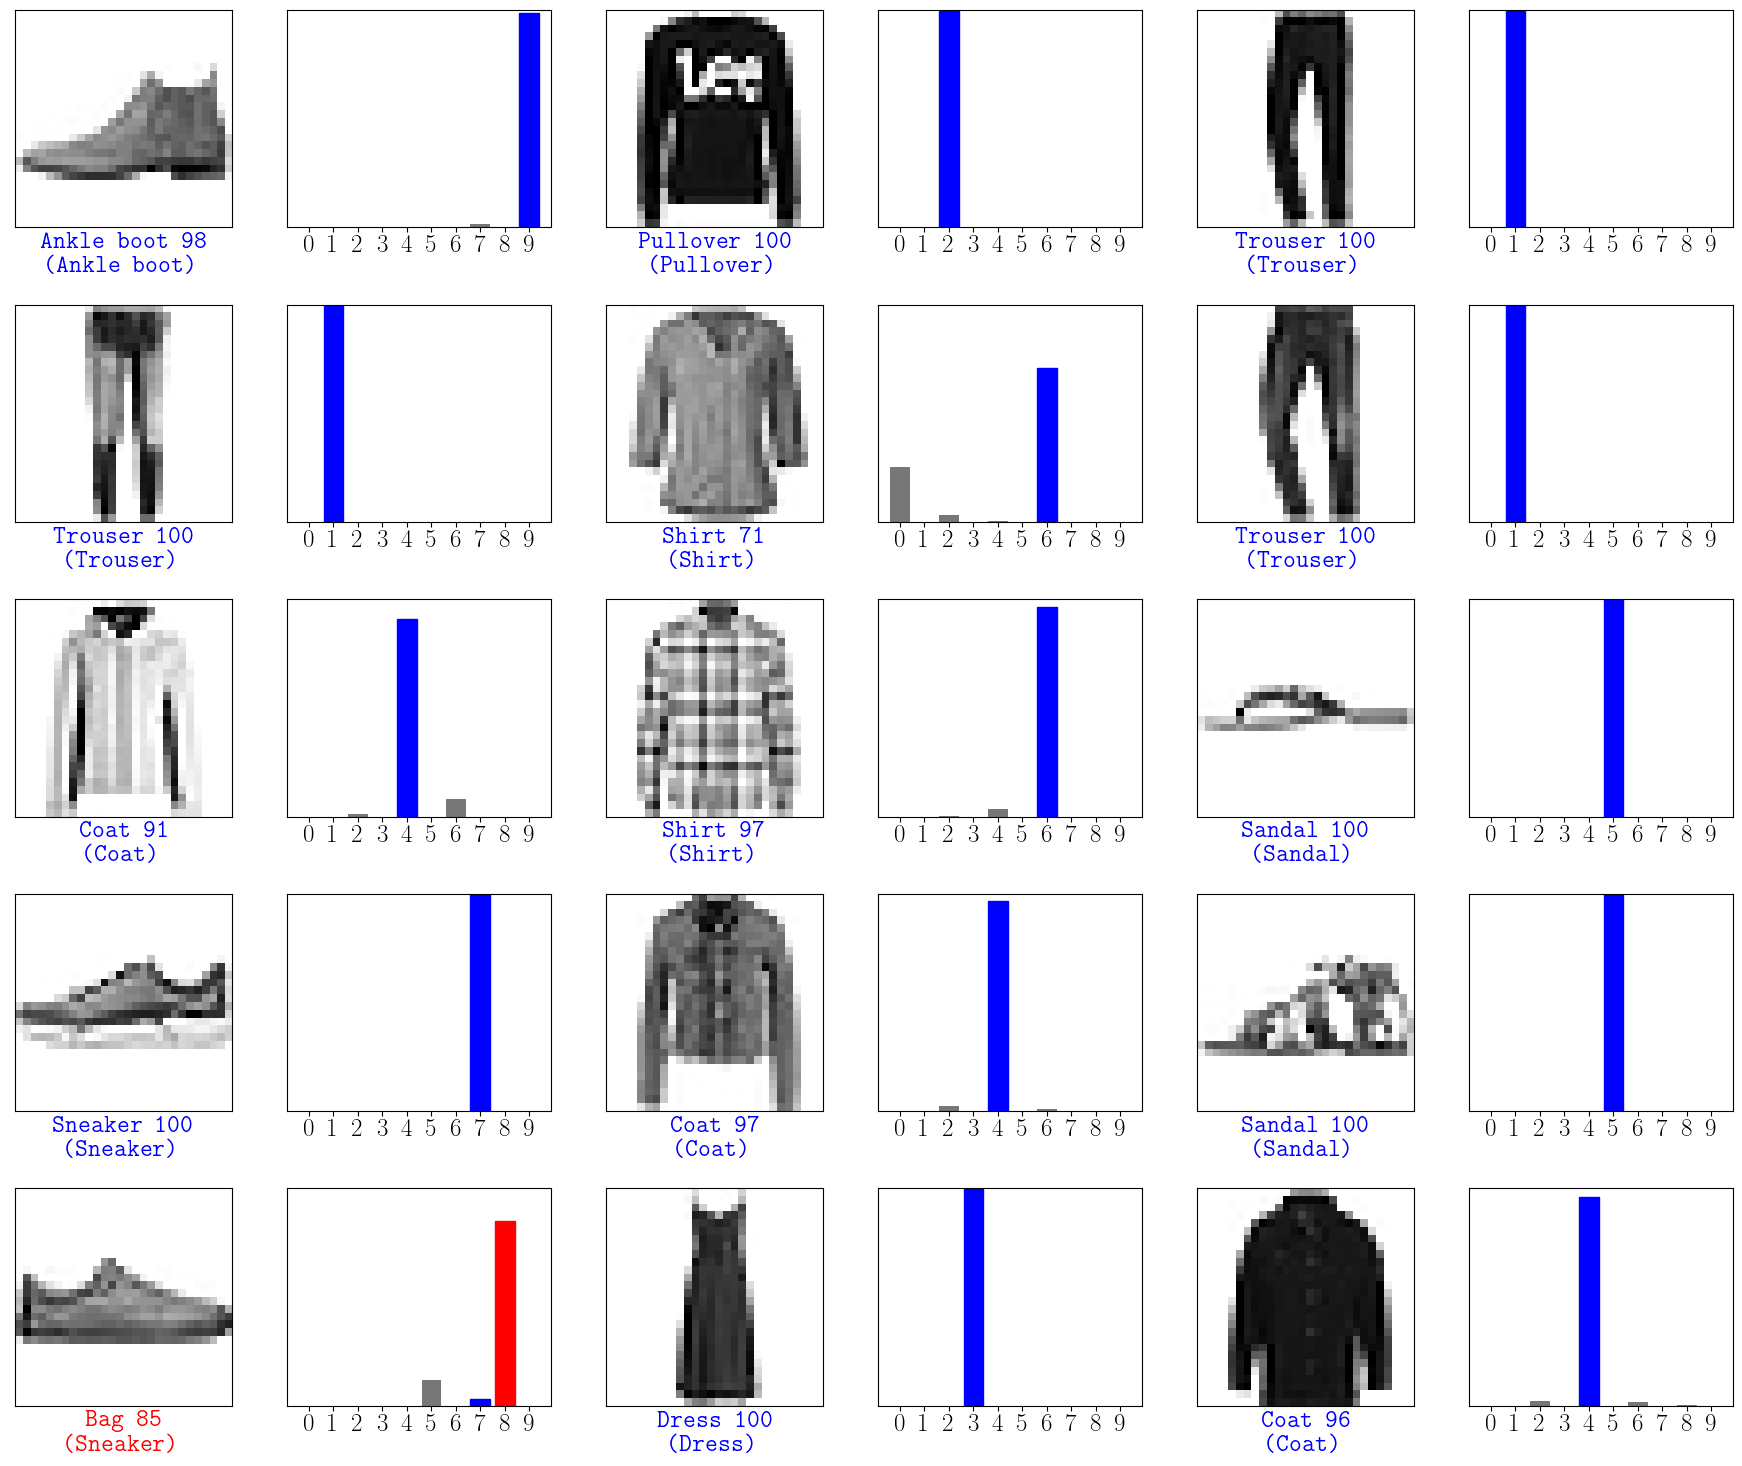

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 3*num_rows))
for i in range(num_images):
    img, true_class = test_set[i]
    predictions_array = probability_model(img)
    
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(img, true_class, predictions_array, test_set.classes)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(img, true_class, predictions_array)
plt.tight_layout()
plt.show()
plt.tight_layout()

## Use the trained model

You can use the model to predict either a single image or a batch of images at once.
One thing to remember is that the input has to have the batch dimension even if you are predicting a single image.

To use the model that you just trained, you can just call the model on an image or a set of images.
If it's a single image prediction, you will need to add another dimension to the image tensor with just a single number "1" in there.

For example, if your image dimension is `WxH`, you would need to convert it to `1xWxH` to show that there is a single image in the minibatch. However, if there are a lot of images you can leave the dimensions as is: `NxWxH` is a valid input dimension.

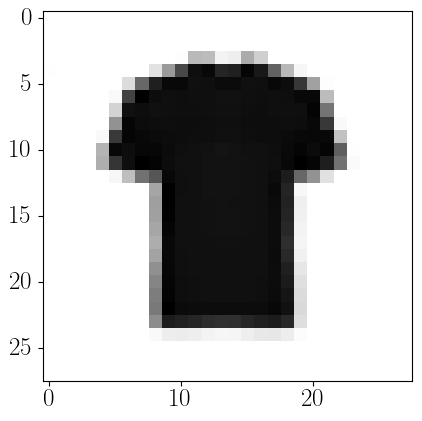

In [24]:
from PIL import Image
import requests

url = 'https://st.depositphotos.com/1377864/2119/i/600/depositphotos_21194933-stock-photo-t-shirt-back-isolated-on.jpg'

img = Image.open(requests.get(url, stream=True).raw)
img = img.resize((28, 28))
img = img.convert('L')
img = np.array(img)
img = np.expand_dims(img, 0)
img = torch.from_numpy(img)

# Need to normalize the image by 255.
# Also need to invert the colors to make them similar to the training images.
img = 1.0 - (img / 255.0)
plt.imshow(img[0], cmap=plt.cm.binary)

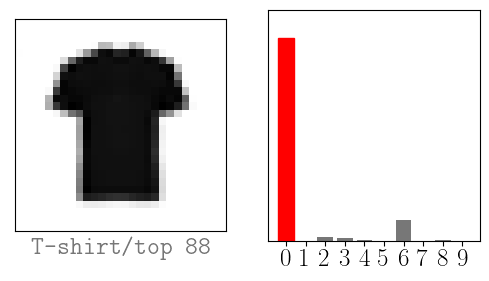

In [25]:
predictions_array = probability_model(img)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(img, -1, predictions_array, test_set.classes)
plt.subplot(1,2,2)
plot_value_array(img, -1, predictions_array)
plt.show()

Let's see what the top predictions are

In [26]:
numpy_predictions = predictions_array.detach().flatten().numpy()
sorted_predictions_index = np.argsort(numpy_predictions)

print("Predictions by confidence:")
for index in sorted_predictions_index[::-1]:
    confidence = numpy_predictions[index]
    label = test_set.classes[index]
    print(f'{label:>12}: {confidence:.2%}')

Predictions by confidence:
 T-shirt/top: 87.68%
       Shirt: 8.86%
    Pullover: 1.72%
       Dress: 0.90%
         Bag: 0.43%
        Coat: 0.40%
     Trouser: 0.01%
      Sandal: 0.00%
  Ankle boot: 0.00%
     Sneaker: 0.00%
